# CNN_UTK_Model for AgeRange 6 class classification - Canny Edges - Dropout-Augmentation

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
plt.style.use('ggplot')

### Data preprocessing

In [2]:
df = pd.read_csv('./dataset/UTK_dataset.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [4]:
df.describe()

,age,ethnicity,gender
count,23705.000000,23705.000000,23705.000000
mean,33.300907,1.269226,0.477283
std,19.885708,1.345638,0.499494
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,1.000000,0.000000
75%,45.000000,2.000000,1.000000
max,116.000000,4.000000,1.000000


In [5]:
df.isna().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [6]:
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [7]:
len(df['age'].unique())

104

### Data analysis

<AxesSubplot:xlabel='age', ylabel='Count'>

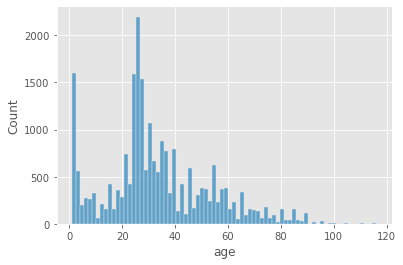

In [8]:
sns.histplot(data=df, x='age')

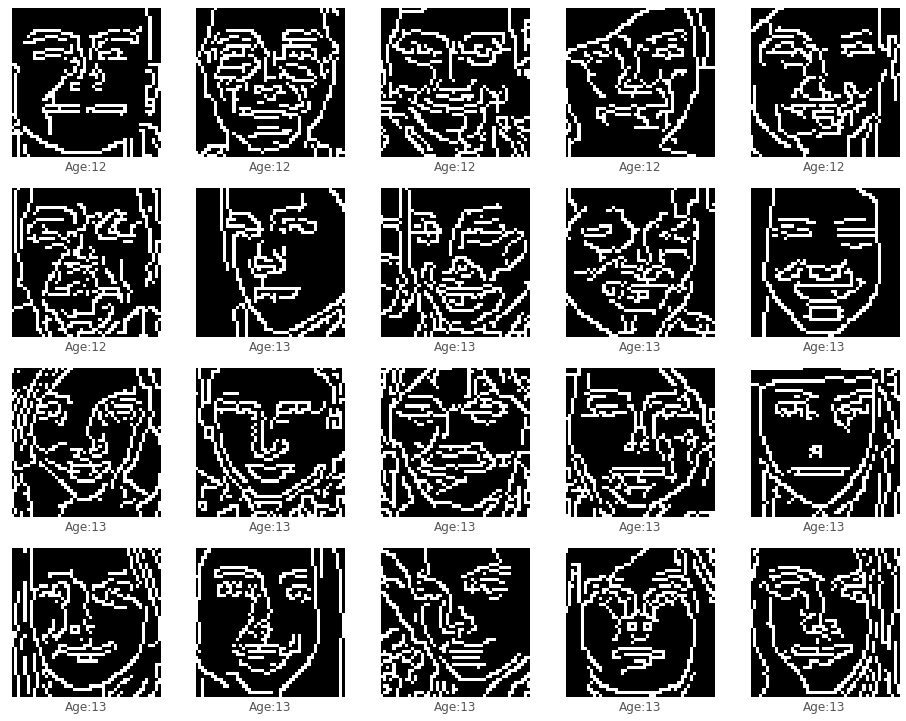

In [9]:
plt.figure(figsize=(16,16))
for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = df['pixels'].iloc[i].reshape(48,48).astype( np.uint8)
    plt.imshow(cv2.Canny(img, 50, 200), cmap='gray')
    plt.xlabel(
        "Age:"+str(df['age'].iloc[i]))
plt.show()

In [10]:
df['pixels']=df['pixels'].apply(lambda x:  cv2.Canny(x.reshape(48,48).astype( np.uint8), 50, 200).reshape(2304))

In [11]:
X = np.array(df['pixels'].tolist())
# taking range of 5
y = df['age'] // 20

In [12]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [13]:
X = X.reshape(X.shape[0],48,48,1)

In [14]:
X[:5].shape

(5, 48, 48, 1)

In [15]:
y.unique()

array([0, 5, 1, 2, 3, 4], dtype=int64)

In [16]:
y = to_categorical(y, num_classes=6)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2, 
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator()

### Model creation

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [21]:
model = Sequential()

model.add(InputLayer(input_shape=(48, 48, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          1

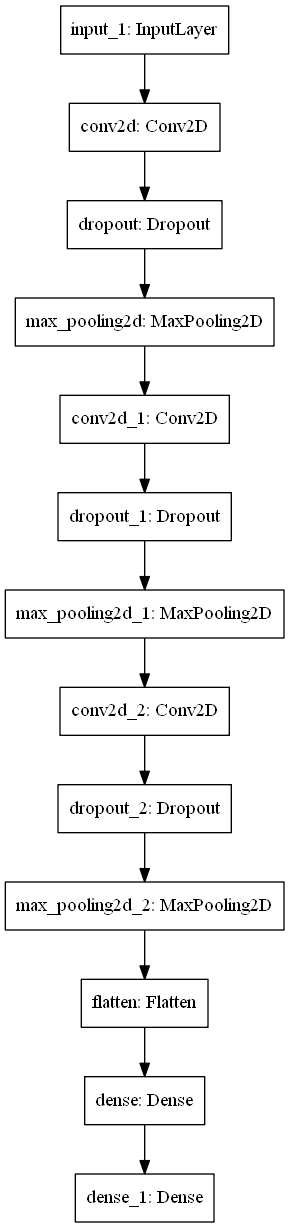

In [22]:
plot_model(model, to_file='models/cnn_utk_model_2_age-range-classification_6classes_canny-dropout-aug.png')

In [23]:
filepath = 'checkpoints/age_range_model2_classification_6classes_canny-dropout-aug.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, mode="min", verbose=1)

In [24]:
model.fit(train_datagen.flow(
        X_train, y_train,
        batch_size = 64
    ), epochs=30, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/30
334/334 [==============================] - ETA: 0s - loss: 1.1827 - accuracy: 0.5347 - mae: 0.2031
Epoch 00001: val_loss improved from inf to 1.13624, saving model to checkpoints\age_range_model2_classification_6classes_canny-dropout-aug.epoch01-loss1.14.hdf5
334/334 [==============================] - 89s 268ms/step - loss: 1.1827 - accuracy: 0.5347 - mae: 0.2031 - val_loss: 1.1362 - val_accuracy: 0.5757 - val_mae: 0.2128
Epoch 2/30
334/334 [==============================] - ETA: 0s - loss: 1.0764 - accuracy: 0.5712 - mae: 0.1871
Epoch 00002: val_loss improved from 1.13624 to 1.06973, saving model to checkpoints\age_range_model2_classification_6classes_canny-dropout-aug.epoch02-loss1.07.hdf5
334/334 [==============================] - 88s 263ms/step - loss: 1.0764 - accuracy: 0.5712 - mae: 0.1871 - val_loss: 1.0697 - val_accuracy: 0.5968 - val_mae: 0.2011
Epoch 3/30
334/334 [==============================] - ETA: 0s - loss: 1.0285 - accuracy: 0.5875 - mae: 0.1796
Epoch 00003:

<AxesSubplot:>

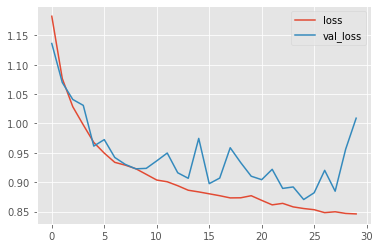

In [25]:
pd.DataFrame(model.history.history)[["loss", "val_loss"]].plot()

In [26]:
from tensorflow.math import argmax

In [27]:
y_pred = argmax(model.predict(X), axis=1)

In [28]:
np.array(y_pred).sum() / len(y_pred)

1.353047880194052

Text(0.5, 1.0, 'Predicted vs Original')

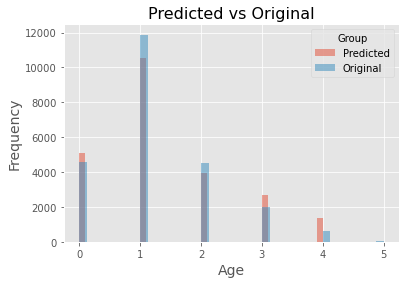

In [29]:
pd.Series((y_pred)).plot(kind='hist', bins=40, label='Predicted', alpha=0.5)
pd.Series(argmax(y, axis = 1)).plot(kind='hist', bins=40, label='Original', alpha=0.5)

plt.legend(title='Group')

plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.title('Predicted vs Original', fontsize=16)

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

<AxesSubplot:>

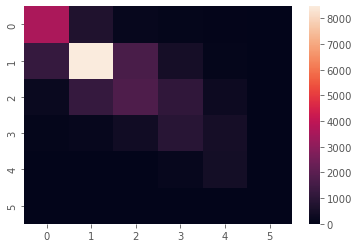

In [31]:
sns.heatmap(confusion_matrix(argmax(y, axis = 1), y_pred))

In [32]:
print(classification_report(argmax(y, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      4593
           1       0.80      0.71      0.75     11880
           2       0.44      0.38      0.41      4544
           3       0.34      0.45      0.38      2015
           4       0.32      0.69      0.44       641
           5       0.00      0.00      0.00        32

    accuracy                           0.64     23705
   macro avg       0.43      0.50      0.46     23705
weighted avg       0.66      0.64      0.64     23705



C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
y_pred.numpy()

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

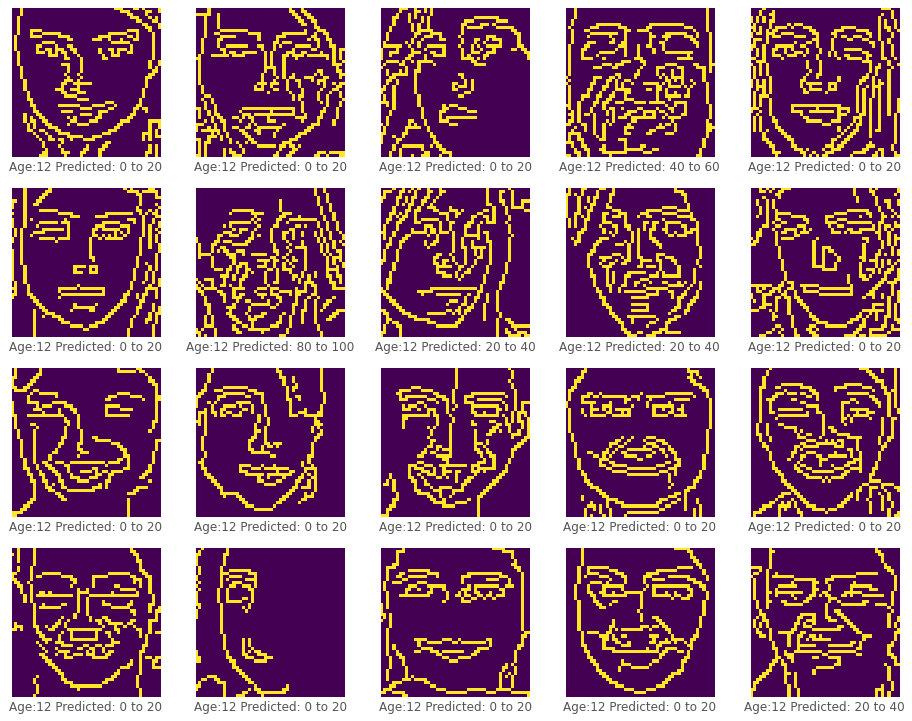

In [34]:
plt.figure(figsize=(16,16))
for i in range(1400,1420):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48,48))
    pred_age = (20 * (y_pred.numpy()[i]))
    plt.xlabel(
        "Age:"+str(df['age'].iloc[i])+" Predicted: "+str(pred_age) + " to " + str(pred_age + 20))
plt.show()

### Predictions for best model

In [35]:
import os
path = os.getcwd() + r'\checkpoints\age_range_model2_classification_6classes_canny-dropout-aug.epoch16-loss0.90.hdf5'

In [36]:
best_model = tf.keras.models.load_model(path)

In [37]:
y_pred_best = argmax(best_model.predict(X), axis=1)

Text(0.5, 1.0, 'Predicted vs Original')

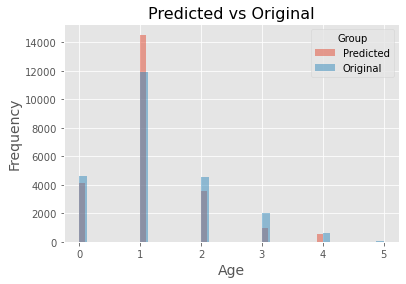

In [38]:
pd.Series((y_pred_best)).plot(kind='hist', bins=40, label='Predicted', alpha=0.5)
pd.Series(argmax(y, axis = 1)).plot(kind='hist', bins=40, label='Original', alpha=0.5)

plt.legend(title='Group')

plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.title('Predicted vs Original', fontsize=16)

<AxesSubplot:>

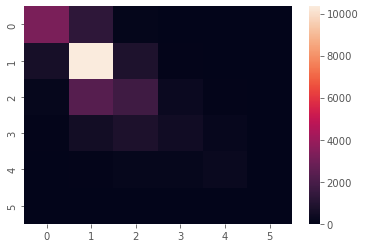

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(confusion_matrix(argmax(y, axis = 1), y_pred_best))

In [40]:
print(classification_report(argmax(y, axis = 1), y_pred_best))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      4593
           1       0.71      0.87      0.78     11880
           2       0.48      0.38      0.43      4544
           3       0.49      0.24      0.32      2015
           4       0.49      0.39      0.43       641
           5       0.00      0.00      0.00        32

    accuracy                           0.68     23705
   macro avg       0.49      0.43      0.45     23705
weighted avg       0.66      0.68      0.66     23705



C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


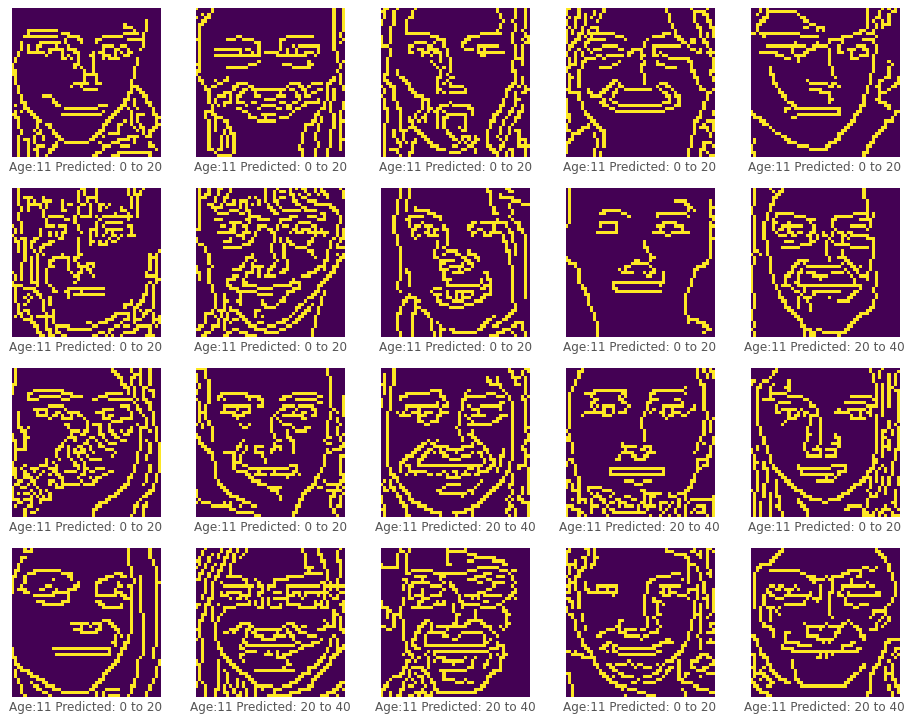

In [41]:
plt.figure(figsize=(16,16))
for i in range(1300,1320):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48,48))
    pred_age = (20 * (y_pred_best.numpy()[i]))
    plt.xlabel(
        "Age:"+str(df['age'].iloc[i])+" Predicted: "+str(pred_age) + " to " + str(pred_age + 20))
plt.show()